# Воркшоп от компании Samokat.tech (Векторный поиск в задаче матчинга)

## Описание проекта

Одной из задач машинного обучения является сопостоваление товаров друг с другом (задача матчинга). В контексте предложенной задачи в рамках воркшопа от компании Samokat.tech необходимо было по запросу, найти в базе продукт наиболее соответствующий требованиям и предложить релевантный результат из 10 объектов.

### Задачи

* Провести анализ данных.
* Подготовить решение.
* Принять участие в соревнованиях на [платформе Kaggle](https://www.kaggle.com/competitions/samokattechworkshop/overview)

### Предложенное решение

* В ходе анализа данных было установлено, что признаки имеют разное распределение, как по среднему так и по дисперсии. При этом есть признаки, которые имеют не нормальное распределение и значительный разброс значений. Учитывая, что в основной части планировалось использовать алгоритмы, работающие на расстояниях между образцами, то было принято решение использовать для масштабирования RobustScaler.

* В качестве модели предложено использовать Faiss. Это достаточно мощный и быстрый инструмент, который позволяет находить ближайшие образцы. Были проанализированы оптимальные параметры для Faiss, также методом перебора были отсеяны шумные признаки, которые ухудшали качество модели. В результате метрика стала ровна 0.7507, что поволило занять 4 место на соревновании.

## EDA

Импортируем нужные зависимости и пропишем пути к файлам.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import RobustScaler
import pickle
from statistics import mean
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.neighbors import NearestNeighbors
import faiss

In [2]:
PATH_RAW_BASE = '../data/raw/base.csv' # Путь к оригинальному base датасету
PATH_RAW_TRAIN = '../data/raw/train.csv' # Путь к оригинальному train датасету
PATH_RAW_TEST = '../data/raw/test.csv' # Путь к оригинальному test датасету

PATH_PROC_BASE = '../data/processed/processed_base.csv' # Путь к обработанному base датасету
PATH_ID_BASE = '../data/processed/id_base.csv' # Путь к датасету Id base
PATH_PROC_TRAIN = '../data/processed/processed_train.csv' # Путь к обработанному train датасету
PATH_TARGET_TRAIN = '../data/processed/id_target_train.csv' # Путь к таргету train
PATH_PROC_TEST = '../data/processed/processed_test.csv' # Путь к обработанному test датасету
PATH_ID_TEST = '../data/processed/id_test.csv' # Путь к датасету Id test

PATH_SAVE_PREDICT = '../data/prediction/scaler_faiss.csv' # Путь к сохранению предсказания

PATH_SCALER = '../models/scaler.pkl' # Путь к scaler
PATH_MODEL = '../models/model.pkl' # Путь к финальной модели

In [3]:
RANDOM_STATE = 134

### Базовый датасет

Откроем файл с базой и изучим его

In [4]:
df_base = pd.read_csv(PATH_RAW_BASE)
df_base.head()

,Id,0,1,2,3,4,5,6,7,8,...,62,63,64,65,66,67,68,69,70,71
0,0-base,-115.083890,11.152912,-64.426760,-118.88089,216.482440,-104.698060,-469.070588,44.348083,120.915344,...,-42.808693,38.800827,-151.76218,-74.389090,63.66634,-4.703861,92.933610,115.269190,-112.756640,-60.830353
1,1-base,-34.562202,13.332763,-69.787610,-166.53348,57.680607,-86.098370,-85.076666,-35.637436,119.718636,...,-117.767525,41.100000,-157.82940,-94.446806,68.20211,24.346846,179.937930,116.834000,-84.888941,-59.524610
2,2-base,-54.233746,6.379371,-29.210136,-133.41383,150.895830,-99.435326,52.554795,62.381706,128.951450,...,-76.397800,46.011803,-207.14442,127.325570,65.56618,66.325680,81.073490,116.594154,-1074.464888,-32.527206
3,3-base,-87.520130,4.037884,-87.803030,-185.06763,76.369540,-58.985165,-383.182845,-33.611237,122.031910,...,-70.647940,-6.358921,-147.20105,-37.692750,66.20289,-20.566910,137.206940,117.474100,-1074.464888,-72.915490
4,4-base,-72.743850,6.522049,43.671265,-140.60803,5.820023,-112.074080,-397.711282,45.182500,122.167180,...,-57.199104,56.642403,-159.35184,85.944724,66.76632,-2.505783,65.315285,135.051590,-1074.464888,0.319401


In [5]:
df_base.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2918139 entries, 0 to 2918138
Data columns (total 73 columns):
 #   Column  Dtype  
---  ------  -----  
 0   Id      object 
 1   0       float64
 2   1       float64
 3   2       float64
 4   3       float64
 5   4       float64
 6   5       float64
 7   6       float64
 8   7       float64
 9   8       float64
 10  9       float64
 11  10      float64
 12  11      float64
 13  12      float64
 14  13      float64
 15  14      float64
 16  15      float64
 17  16      float64
 18  17      float64
 19  18      float64
 20  19      float64
 21  20      float64
 22  21      float64
 23  22      float64
 24  23      float64
 25  24      float64
 26  25      float64
 27  26      float64
 28  27      float64
 29  28      float64
 30  29      float64
 31  30      float64
 32  31      float64
 33  32      float64
 34  33      float64
 35  34      float64
 36  35      float64
 37  36      float64
 38  37      float64
 39  38      float64
 40  

В данных первый столбец является наименованием, остальные просто векторные представления объектов. При этом числовые столбцы представлены во float64 их можно преобразовать во float32, это незначительно уменьшит точность, но позволит уменьшить объём.

In [6]:
df_base[df_base.select_dtypes(include='float').columns] = df_base.select_dtypes(include='float').astype('float32')

Посмотрим как меняются данные в столбцах

In [7]:
df_base.describe()

,0,1,2,3,4,5,6,7,8,9,...,62,63,64,65,66,67,68,69,70,71
count,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,...,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06
mean,-8.622946e+01,8.080074e+00,-4.458079e+01,-1.466350e+02,1.113166e+02,-7.199137e+01,-3.922237e+02,2.035283e+01,1.236843e+02,1.244581e+02,...,-7.902287e+01,3.329736e+01,-1.547961e+02,1.415133e+01,6.779169e+01,2.354489e+01,7.495934e+01,1.155667e+02,-7.993393e+02,-4.779124e+01
std,2.489132e+01,4.953387e+00,3.863166e+01,1.984480e+01,4.634809e+01,2.818607e+01,2.716550e+02,6.421638e+01,6.356110e+00,6.443058e+01,...,3.045642e+01,2.888603e+01,4.122929e+01,9.895115e+01,1.823356e+00,5.534224e+01,6.134501e+01,2.117518e+01,3.854131e+02,4.174802e+01
min,-1.994687e+02,-1.391461e+01,-2.400734e+02,-2.326671e+02,-1.055830e+02,-2.110086e+02,-7.914698e+02,-3.018597e+02,9.315305e+01,-1.738719e+02,...,-2.205663e+02,-8.850774e+01,-3.539028e+02,-1.575944e+02,5.950945e+01,-2.331382e+02,-2.036016e+02,1.572448e+01,-1.297932e+03,-2.267801e+02
25%,-1.030654e+02,4.708491e+00,-6.955949e+01,-1.599051e+02,8.050795e+01,-9.137994e+01,-6.293318e+02,-2.222147e+01,1.194840e+02,8.176751e+01,...,-9.876390e+01,1.698862e+01,-1.807798e+02,-7.130038e+01,6.658096e+01,-1.251624e+01,3.377574e+01,1.016867e+02,-1.074465e+03,-7.566641e+01
50%,-8.623150e+01,8.038950e+00,-4.381660e+01,-1.467768e+02,1.118730e+02,-7.192230e+01,-4.222016e+02,2.080477e+01,1.238923e+02,1.234977e+02,...,-7.848812e+01,3.471502e+01,-1.539773e+02,1.382693e+01,6.781458e+01,2.341649e+01,7.492997e+01,1.160244e+02,-1.074465e+03,-4.859196e+01
75%,-6.925658e+01,1.147007e+01,-1.962527e+01,-1.333277e+02,1.423743e+02,-5.244110e+01,-1.566686e+02,6.391821e+01,1.279705e+02,1.672206e+02,...,-5.853355e+01,5.216429e+01,-1.273405e+02,9.966753e+01,6.902666e+01,5.975511e+01,1.158760e+02,1.295524e+02,-5.057444e+02,-1.971424e+01
max,2.151555e+01,2.993721e+01,1.609372e+02,-5.137478e+01,3.196645e+02,5.880624e+01,1.096325e+02,3.412282e+02,1.522612e+02,4.275421e+02,...,6.017411e+01,1.541678e+02,2.436099e+01,1.850981e+02,7.571203e+01,3.148988e+02,3.395739e+02,2.147063e+02,9.877081e+01,1.269732e+02


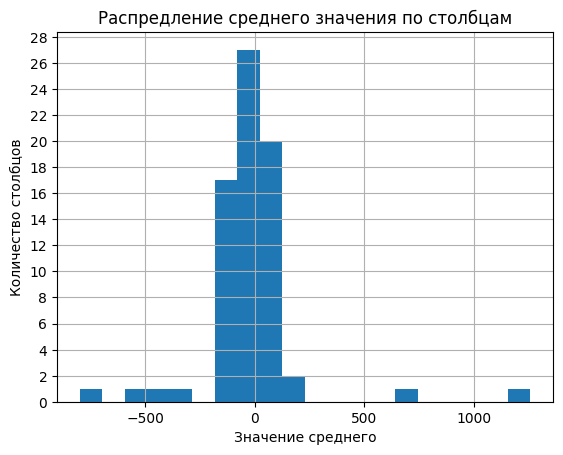

In [8]:
plt.title('Распредление среднего значения по столбцам')
plt.hist(df_base.select_dtypes(include='float').mean(),
        bins=20)
plt.yticks(range(0, 30, 2))
plt.grid()
plt.xlabel('Значение среднего')
plt.ylabel('Количество столбцов')           
plt.show()

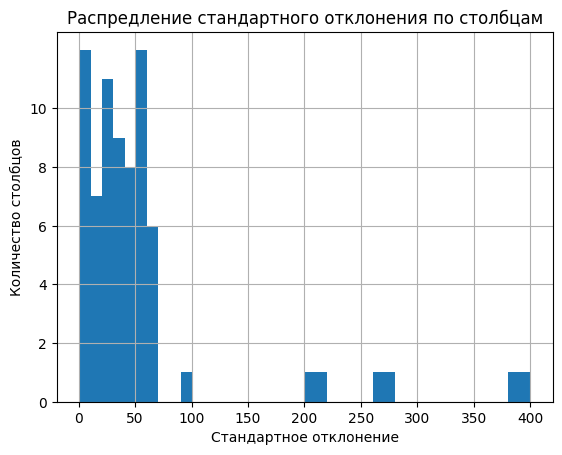

In [9]:
plt.title('Распредление стандартного отклонения по столбцам')
plt.hist(df_base.select_dtypes(include='float').std(),
        bins=40)
plt.yticks(range(0, 12, 2))
plt.grid()
plt.xlabel('Стандартное отклонение')
plt.ylabel('Количество столбцов')           
plt.show()

Основная часть стандартных отклонений и среднего по столбцам распределена около нуля, однако есть несколько столбцов со значениями значительно превосходящие остальные. Учитывая, что для определения схожести продуктов зачастую используется расстояние, то ко всем столбцам необходимо будет применить стандартизацию , азтем изменить тренировочные и тестовые датасеты.

Выведим столбцы с большим стандартным отклонением

In [10]:
list_column = []
for i in range(0, 72):
    column = df_base.select_dtypes(include='float').columns[i]
    if df_base[column].std() > 80:
        list_column.append(column)
list_column

['6', '21', '25', '33', '59', '65', '70']

В процессе обучения необходимо будет посмотреть как влиют данные столбцы на качество обучения. Возможно некоторые из них являются шумом

Построим график с количеством разных значений

In [11]:
list_count = []
for i in range(0, 72):
    column = df_base.select_dtypes(include='float').columns[i]
    list_count.append(len(df_base[column].value_counts()))

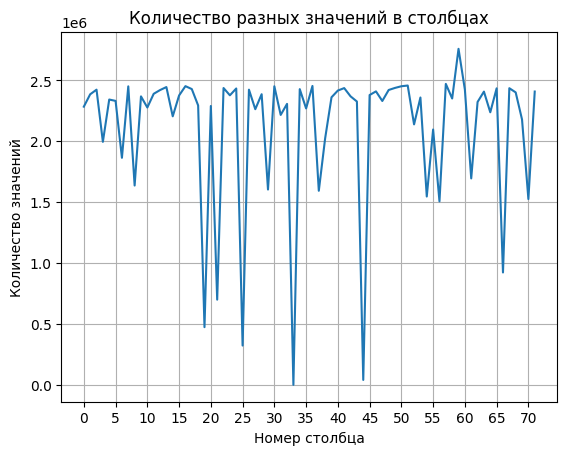

In [12]:
plt.title('Количество разных значений в столбцах')
plt.plot(range(0, 72), list_count)
plt.xlabel('Номер столбца')
plt.xticks(range(0, 75, 5))
plt.ylabel('Количество значений')
plt.grid()
plt.show()

Из графика видно, что есть столбцы с очень маленьким количеством разных значений, вероятнее всего, такие столбцы также не будут улучшать качество модели, но при этом будут добавлять лишнюю размерность.

### Тестовый и тренировочный датасеты

Откроем тренировочный и тестовый датасеты и изучим их

In [13]:
df_train = pd.read_csv(PATH_RAW_TRAIN)
df_train.head()

,Id,0,1,2,3,4,5,6,7,8,...,63,64,65,66,67,68,69,70,71,Target
0,0-query,-53.882748,17.971436,-42.117104,-183.93668,187.517490,-87.144930,-347.360606,38.307602,109.085560,...,70.107360,-155.80257,-101.965943,65.903790,34.457500,62.642094,134.763600,-415.750254,-25.958572,675816-base
1,1-query,-87.776370,6.806268,-32.054546,-177.26039,120.803330,-83.810590,-94.572749,-78.433090,124.915900,...,4.669178,-151.69771,-1.638704,68.170876,25.096191,89.974976,130.589630,-1035.092211,-51.276833,366656-base
2,2-query,-49.979565,3.841486,-116.118590,-180.40198,190.128430,-50.837620,26.943937,-30.447489,125.771164,...,78.039764,-169.14620,82.144186,66.008220,18.400496,212.409730,121.931470,-1074.464888,-22.547178,1447819-base
3,3-query,-47.810562,9.086598,-115.401695,-121.01136,94.652840,-109.255410,-775.150134,79.186520,124.003100,...,44.515266,-145.41675,93.990981,64.131350,106.061920,83.178760,118.277725,-1074.464888,-19.902788,1472602-base
4,4-query,-79.632126,14.442886,-58.903397,-147.05254,57.127068,-16.239529,-321.317964,45.984676,125.941284,...,45.028910,-196.09207,-117.626337,66.926220,42.456170,77.621765,92.479930,-1074.464888,-21.149351,717819-base


In [14]:
df_test = pd.read_csv(PATH_RAW_TEST)
df_test.head()

,Id,0,1,2,3,4,5,6,7,8,...,62,63,64,65,66,67,68,69,70,71
0,100000-query,-57.372734,3.597752,-13.213642,-125.92679,110.74594,-81.279594,-461.003172,139.815720,112.880980,...,-75.51302,52.830902,-143.43945,59.051935,69.28224,61.927513,111.59253,115.140656,-1099.130485,-117.079360
1,100001-query,-53.758705,12.790300,-43.268543,-134.41762,114.44991,-90.520130,-759.626065,63.995087,127.117905,...,-79.44183,29.185436,-168.60590,-82.872443,70.76560,-65.975950,97.07716,123.391640,-744.442332,-25.009320
2,100002-query,-64.175095,-3.980927,-7.679249,-170.16093,96.44616,-62.377740,-759.626065,87.477554,131.270110,...,-134.79541,37.368730,-159.66231,-119.232725,67.71044,86.002060,137.63641,141.081630,-294.052271,-70.969604
3,100003-query,-99.286860,16.123936,9.837166,-148.06044,83.69708,-133.729720,58.576403,-19.046660,115.042404,...,-77.23611,44.100494,-132.53012,-106.318982,70.88396,23.577892,133.18396,143.252940,-799.363667,-89.392670
4,100004-query,-79.532920,-0.364173,-16.027431,-170.88495,165.45392,-28.291668,33.931936,34.411217,128.903980,...,-123.77025,45.635944,-134.25893,13.735359,70.61763,15.332115,154.56812,101.700640,-1171.892332,-125.307890


Данные имеют схожую структуру, однако первый столбец имеет форматы запроса, его нужно будет удалить и будем использовать только при создании предсказаний на лидерборд. Преобразуем все float64 во float32

In [15]:
df_train[df_train.select_dtypes(include='float').columns] = df_train.select_dtypes(include='float').astype('float32')

In [16]:
df_test[df_test.select_dtypes(include='float').columns] = df_test.select_dtypes(include='float').astype('float32')

Изучим как соотносятся средние и стандартное отклонение на тестовой и тренировочной выборке

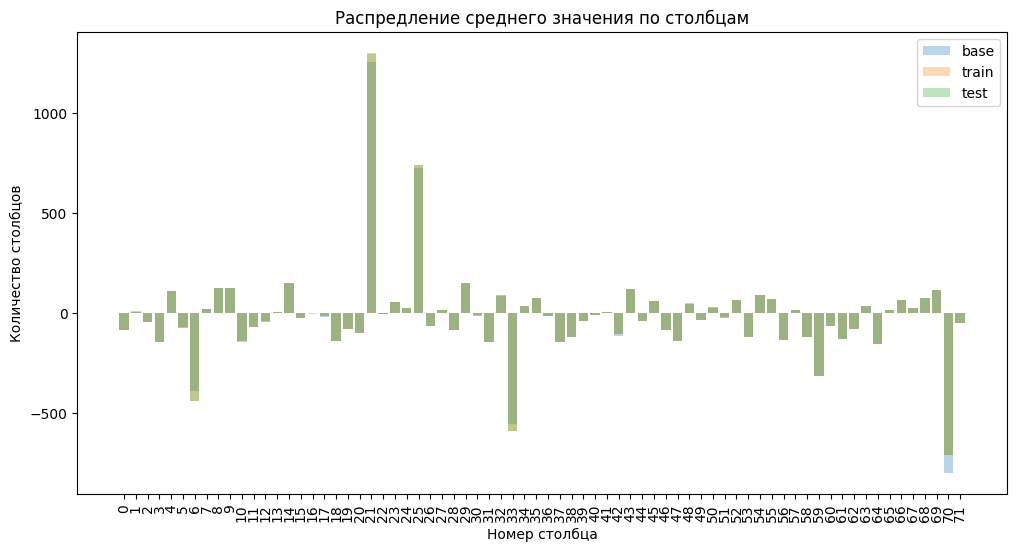

In [17]:
plt.figure(figsize=(12,6))
plt.title('Распредление среднего значения по столбцам')
plt.bar(df_base.select_dtypes(include='float').mean().index,
        df_base.select_dtypes(include='float').mean(),
       alpha=0.3,
       label='base')
plt.bar(df_train.select_dtypes(include='float').mean().index,
        df_train.select_dtypes(include='float').mean(),
       alpha=0.3,
       label='train')
plt.bar(df_test.select_dtypes(include='float').mean().index,
        df_test.select_dtypes(include='float').mean(),
       alpha=0.3,
       label='test')
plt.xticks(rotation=90)
plt.xlabel('Номер столбца')
plt.ylabel('Количество столбцов') 
plt.legend()
plt.show()

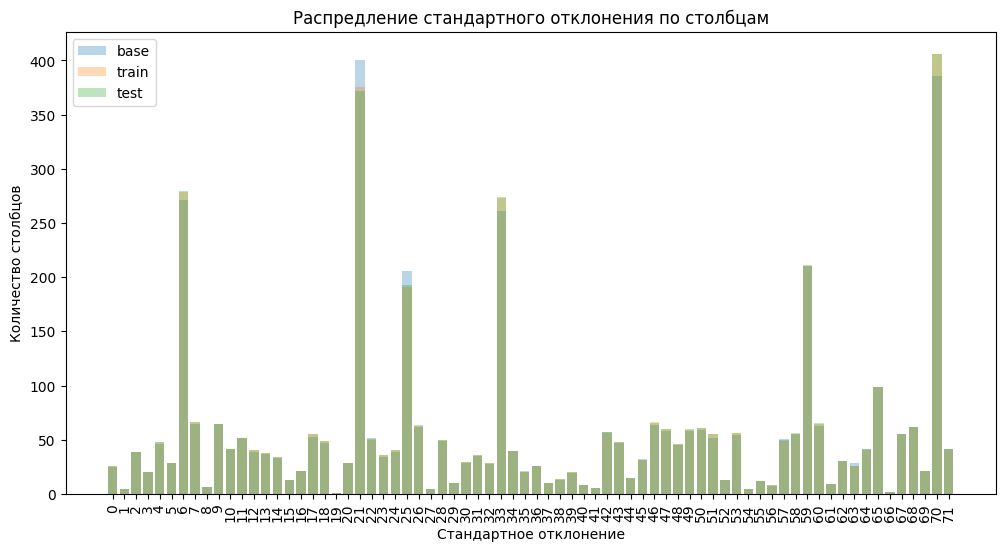

In [18]:
plt.figure(figsize=(12,6))
plt.title('Распредление стандартного отклонения по столбцам')
plt.bar(df_base.select_dtypes(include='float').std().index,
        df_base.select_dtypes(include='float').std(),
       alpha=0.3,
       label='base')
plt.bar(df_train.select_dtypes(include='float').std().index,
        df_train.select_dtypes(include='float').std(),
       alpha=0.3,
       label='train')
plt.bar(df_test.select_dtypes(include='float').std().index,
        df_test.select_dtypes(include='float').std(),
       alpha=0.3,
       label='test')
plt.xticks(rotation=90)
plt.xlabel('Стандартное отклонение')
plt.ylabel('Количество столбцов') 
plt.legend()
plt.show()

Среднее значение и стандартоное отклонение в общей базе, трейновом и тестовом наборепочти полностью совпадают, соответствено адекватная модель должна давать сходие результате на трейне и тесте.

Посмотрим какие целевые товары чаще встречаются в таргете, возможно получится создать dammy модель, которая будет всме рекомендовать наиболее часто встречающиеся товары.

In [19]:
df_train['Target'].value_counts()

Target
41568-base      7
18784-base      7
106681-base     6
7473-base       6
90018-base      6
               ..
1554551-base    1
831164-base     1
2309177-base    1
1242930-base    1
2769109-base    1
Name: count, Length: 91794, dtype: int64

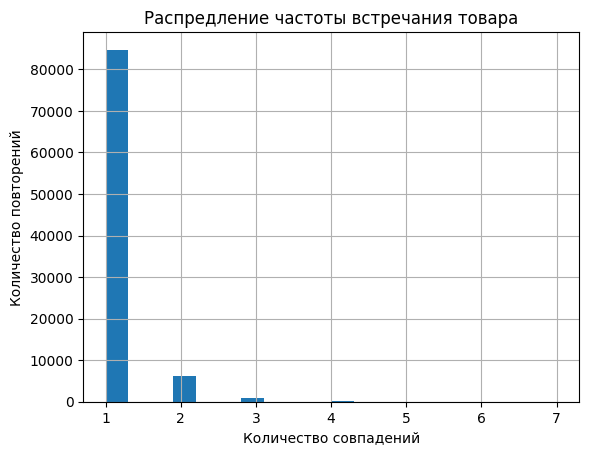

In [20]:
plt.title('Распредление частоты встречания товара')
plt.hist(df_train['Target'].value_counts(),
        bins=20)
plt.grid()
plt.xlabel('Количество совпадений')
plt.ylabel('Количество повторений')           
plt.show()

Большинство товаров встречается только один раз, поэтому дамми модель, которая будет всем указывать наиболее частые товары, вряд ли покажет нормальные результаты.

### Выводы

Был проведён анализ данных, в ходе которого:

    1. Принято решение изменить тип данных для чисел с плавающей точкой на float32, для ускорения рассчётов.
    2. Изучено расспределение данных в базе, на основании которого принято решение стандартизировать данные перед обучением, поскольку есть столбцы, значения в которых сильно отличаются от остальных.
    3. Проведён анализ распределения значений в первоначальной базе тестовом и тренировочном наборе. Было установлено, что данные распределены схожи.
    4. Отвергнута dammy модель, которая бы предсказывала наиболее часто встречающиеся товары. 

## Предобработка данных

Преобразуем данные с учётом проведённого анализа, для этого напишем две функции, одна будет обрабатывать базовый датасет со всеми товарами, а вторая тренировочный и тестовый датасет. Обработанные файлы будем записывать в  новые файлы, чтобы в дальнейшем можно было уже использовать предобработанные датасеты.

In [21]:
def preprocessing_base(input_path: str,
                       output_path_data: str,
                       output_path_id: str,
                       output_path_scaler: str):
    """Функция для предообработки базового датасета
    :param input_path: Путь к оригинальному датасету
    :param output_path_data: Путь для записи обработаннумого датасета
    :param output_path_id: Путь для записи датасета с Id
    :param output_path_scaler: Путь для записи scaler (.pkl)
    """
    df = pd.read_csv(input_path)
    df_id = df['Id']
    df = df.drop(['Id'], axis=1)
    df[df.select_dtypes(include='float').
       columns] = df.select_dtypes(include='float').astype('float32')

    scaler = RobustScaler()
    df_scaled = scaler.fit_transform(df)
    df_scaled = pd.DataFrame(df_scaled)

    df_scaled.to_csv(output_path_data, index=False)
    df_id.to_csv(output_path_id, index=False)

    with open(output_path_scaler, 'wb') as f:
        pickle.dump(scaler, f)

In [22]:
def preprocessing_train_test(input_train_path: str,
                             input_test_path: str,
                             input_scaler_path: str,
                             output_train_path: str,
                             output_test_path: str,
                             output_train_target_path: str,
                             output_test_id_path: str):
    """Функция для предообработки тренировочного и тестового датасета
    :param input_train_path: Путь к оригинальному train датасету
    :param input_test_path: Путь к оригинальному test датасету
    :param input_scaler_path: Путь к обученному scaler (.pkl)
    :param output_train_path: Путь для записи обработанного train датасета
    :param output_test_path: Путь для записи обработанного test датасета
    :param output_train_target_path: Путь для записи таргета из train датасета
    :param output_test_id_path: Путь для записи Id из test датасета
    :return:
    """
    # открываем файлы, выделяем нужные столбцы, приводим типы
    df_train = pd.read_csv(input_train_path)
    df_train_target = df_train[['Id', 'Target']]
    df_train = df_train.drop(['Id', 'Target'], axis=1)
    df_train[df_train.select_dtypes(include='float').
             columns] = df_train.select_dtypes(include='float').astype('float32')

    df_test = pd.read_csv(input_test_path)
    df_test_id = df_test['Id']
    df_test = df_test.drop('Id', axis=1)
    df_test[df_test.select_dtypes(include='float').
            columns] = df_test.select_dtypes(include='float').astype('float32')

    # открываем RobustScaler стандартизируем данные
    with open(input_scaler_path, 'rb') as f:
        scaler: RobustScaler = pickle.load(f)
    df_train = pd.DataFrame(scaler.transform(df_train))
    df_test = pd.DataFrame(scaler.transform(df_test))

    # записываем результаты в файлы
    df_train_target.to_csv(output_train_target_path, index=False)
    df_test_id.to_csv(output_test_id_path, index=False)
    df_train.to_csv(output_train_path, index=False)
    df_test.to_csv(output_test_path, index=False)

In [23]:
preprocessing_base(PATH_RAW_BASE,
                   PATH_PROC_BASE,
                   PATH_ID_BASE,
                   PATH_SCALER)

In [24]:
preprocessing_train_test(PATH_RAW_TRAIN,
                         PATH_RAW_TEST,
                         PATH_SCALER,
                         PATH_PROC_TRAIN,
                         PATH_PROC_TEST,
                         PATH_TARGET_TRAIN,
                         PATH_ID_TEST)

## Обучение моделей

Откроем обработанные датасеты

In [25]:
df_base = pd.read_csv(PATH_PROC_BASE)
df_test = pd.read_csv(PATH_PROC_TEST)
df_train = pd.read_csv(PATH_PROC_TRAIN)

Создадим словарь с Id товаров и загрузим таргет для тренировочного датасета

In [26]:
id_base_dict = dict(pd.read_csv(PATH_ID_BASE)['Id'])
target_train = pd.read_csv(PATH_TARGET_TRAIN)['Target']

Выведем размерности загруженных датасетов, чтобы убедиться, что всё обработанно корректно

In [27]:
df_base.shape, df_test.shape, df_train.shape

((2918139, 72), (100000, 72), (100000, 72))

### Метрика

Согласно условиям соревнования метрикой качества является Recall@10, которую можно рассчитать по формуле:

$$ Recall@10 =  {\sum найденных \space в \space топ10 \space матчей \over \sum матчей} $$

Создадим функцию, которая будет рассчитывать данную метрику

In [28]:
def score_function(y_true, y_pred):
    metrick_list = []
    for i, y_p in enumerate(y_pred):
        metrick_list.append(1 if y_true[i] in y_p.split() else 0)
    return mean(metrick_list)    

### Faiss

Рассмотрим, как с этой задачей справится Faiss.

In [29]:
base = df_base.copy(deep = True)
test = df_test.copy(deep = True)
train = df_train.copy(deep = True)

Создадим функцию, которая на вход будет принимать тестовой и тренировочные датасеты, а возвращать будет показатель метрики. При этом будем рассматривать только 10 тысяч записей датасета, чтобы ускорить обучение.

In [30]:
def train_predict_fias_10k(base, train):
    d = len(base.columns)
    nb = base.shape[0] 
    np.random.seed(RANDOM_STATE) 

    xb = base.values.astype('float32')
    xq_train = train.values.astype('float32')
    
    nlist = 1
    k = 10
    quantizer = faiss.IndexFlatIP(d)  
    index = faiss.IndexIVFFlat(quantizer, d, nlist)
    assert not index.is_trained
    index.train(xb)
    assert index.is_trained
    index.add(xb)
    
    train_10k = train.iloc[:10_000]
    xq_train_10k = xq_train[:10_000]
    target_train_10k = target_train[:10_000]
        
    D, I = index.search(xq_train_10k, k)
    predicted_list = []
    for candidates in I:
        predicted_list.append(' '.join([id_base_dict[candidate] for candidate in candidates]))
    
    return score_function(target_train_10k, predicted_list)

In [31]:
%%time
score_all = train_predict_fias_10k(base, train)
print("Значение метрики на смаштабированном датасете со всеми столбцами равно", score_all)

Значение метрики на смаштабированном датасете со всеми столбцами равно 0.5679
CPU times: total: 45min 43s
Wall time: 4min 9s


Неплохой результат, лучше чем baseline без масштабирования, но попробуем улучшить этот результат.

#### Выбор признаков для обучения

Проверим предположение, что столбцы с высокой дисперсией ухудшают качесвто модели. Для этого удалим данные столбцы и посмотрим на качество модели.

In [32]:
column_drop = list_column
base = base.drop(column_drop, axis=1)
train = train.drop(column_drop, axis=1)

In [33]:
%%time
score = train_predict_fias_10k(base, train)
print("Значение метрики на смаштабированном датасете с удалёнными столбцами с большим стандартным отклонением равно", score)

Значение метрики на смаштабированном датасете с удалёнными столбцами с большим стандартным отклонением равно 0.7474
CPU times: total: 39min 30s
Wall time: 3min 35s


Качество значительно увеличилось, однако, мы могли удалить и значащие столбцы. Учитывая, что количество признаков не слишком много, переберём все столбцы по очереди и найдём те, которые можно удалить, чтобы улучшить качество модели.

In [34]:
base = df_base.copy(deep = True)
train = df_train.copy(deep = True)

In [35]:
column_drop = []
top_score = score_all
for col in tqdm(base.columns):
    column_drop.append(col)
    base = df_base.drop(column_drop, axis=1)
    train = df_train.drop(column_drop, axis=1)
    new_score = train_predict_fias_10k(base, train)
    if top_score > new_score:
        column_drop.remove(col)
    else:
        top_score = new_score    

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 72/72 [4:35:22<00:00, 229.47s/it]


In [60]:
print(f"Значение метрики на смаштабированном датасете с удалёнными столбцами {column_drop} равно {top_score}")

Значение метрики на смаштабированном датасете с удалёнными столбцами ['8', '11', '17', '21', '25', '33', '39', '59', '62', '65'] равно 0.7507


Качество модели немного возрасло. Удалим полученные столбцы из датасетов и в дальнейшем будем экспериментировать уже на них.

In [37]:
base = df_base.copy(deep = True)
test = df_test.copy(deep = True)
train = df_train.copy(deep = True)

In [38]:
base = df_base.drop(column_drop, axis=1)
test = df_test.drop(column_drop, axis=1)
train = df_train.drop(column_drop, axis=1)

In [47]:
xb = base.values.astype('float32')
xq_train = train.values.astype('float32')

In [48]:
train_10k = train.iloc[:10_000]
xq_train_10k = xq_train[:10_000]
target_train_10k = target_train[:10_000]

#### Подбор параметров

У IndexIVFFlat есть два параметра, которые влияют на качество модели и на скорость прогнозирования: nlist и nprobe. Изучим их влияние на качество модели.

In [49]:
%%time
metric_list =[]
for nlist in tqdm(range(1, 1001, 100)):    
    k = 10
    d = len(base.columns)
    quantizer = faiss.IndexFlatIP(d)
    index = faiss.IndexIVFFlat(quantizer, d, nlist)
    assert not index.is_trained
    index.train(xb)
    assert index.is_trained
    index.add(xb)
    
    D, I = index.search(xq_train_10k, k)
    I[I==-1] = 0
    predicted_list = []
    for candidates in I:
        predicted_list.append(' '.join([id_base_dict[candidate] for candidate in candidates]))
    
    metric_list.append(score_function(target_train_10k, predicted_list))

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [04:29<00:00, 26.90s/it]

CPU times: total: 46min 42s
Wall time: 4min 29s


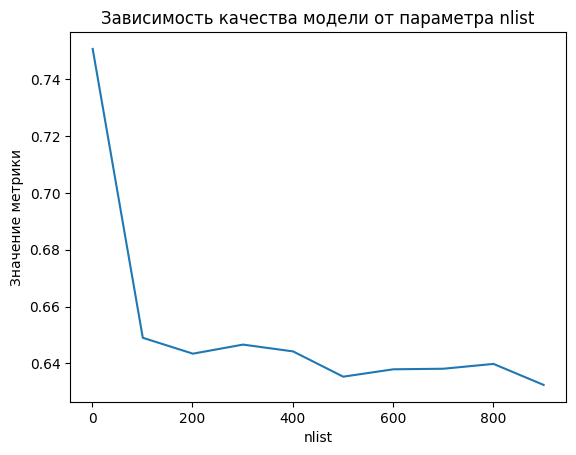

In [50]:
plt.title('Зависимость качества модели от параметра nlist')
plt.plot(range(1, 1001, 100), metric_list)
plt.xlabel('nlist')
plt.ylabel('Значение метрики')
plt.show()

In [51]:
%%time
metric_list =[]
for nprobe in tqdm(range(1, 101, 10)):    
    k = 10
    d = len(base.columns)
    quantizer = faiss.IndexFlatIP(d)
    index = faiss.IndexIVFFlat(quantizer, d, nlist)
    assert not index.is_trained
    index.train(xb)
    assert index.is_trained
    index.add(xb)
    index.nprobe = nprobe
    
    D, I = index.search(xq_train_10k, k)
    I[I==-1] = 0
    predicted_list = []
    for candidates in I:
        predicted_list.append(' '.join([id_base_dict[candidate] for candidate in candidates]))
    
    metric_list.append(score_function(target_train_10k, predicted_list))

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [03:42<00:00, 22.27s/it]

CPU times: total: 38min 7s
Wall time: 3min 42s


При увеличении параметра nlist качество модели ухудшается и начинает выравнивается в районе 0,63 - 0,64

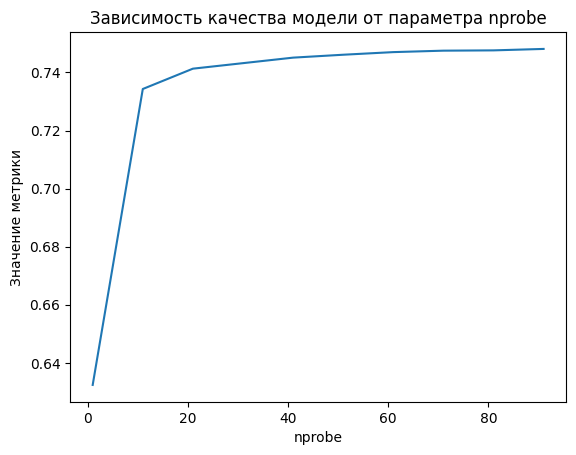

In [52]:
plt.title('Зависимость качества модели от параметра nprobe')
plt.plot(range(1, 101, 10), metric_list)
plt.xlabel('nprobe')
plt.ylabel('Значение метрики')
plt.show()

При увеличении значения параметра nprode качество улучшается, но всё равно остаётся хуже, чем при значению по умолчанию, хотя и приближается к нему при значениях данного параметра выше 50.

### KNN

Проверим какое качества даст алгоритм ближайших соседей.

In [53]:
knn = NearestNeighbors(n_neighbors=k, metric="cosine")
knn.fit(xb)

NearestNeighbors(metric='cosine', n_neighbors=10)

In [54]:
%%time
knn_result = knn.kneighbors(xq_train_10k, n_neighbors=k)
predicted_list = []
for candidates in tqdm(I):
    predicted_list.append(' '.join([id_base_dict[candidate] for candidate in candidates]))

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 128208.93it/s]

CPU times: total: 11min 50s
Wall time: 7min 7s


In [55]:
print("Значение метрики для алгоритма KNN равно", score_function(target_train_10k, predicted_list))

Значение метрики для алгоритма KNN равно 0.7481


Как видим качество модели ближайших соседей не сильно отличается от Faiss, но работает почти в два раза дольше. Поэтому для предсказания на финальном датасете будем использовать Faiss.

### Выводы

В данном разделе были обучены и проанализированны модели Faiss и ближайших соседей. Модель Faiss показала себя немного лучше с точки зрения качества прогноза и значительно лучше с точки зрения производительности. Также в данном разделе были отобраны столбцы, удаление которых позволяет улучшить качество модели (с 0.5679 до 0.7507).

## Прогнозирование результата на тестовом датсете

Обучим выбранную модель и спрогназируем данные для тестового датасета.

In [56]:
d = len(base.columns)
nb = base.shape[0] 
nq = test.shape[0] 
np.random.seed(134) 

xb = base.values.astype('float32')
xq_test = test.values.astype('float32')

nlist = 1
k = 10
quantizer = faiss.IndexFlatIP(d)
index = faiss.IndexIVFFlat(quantizer, d, nlist)
assert not index.is_trained
index.train(xb)
assert index.is_trained
index.add(xb)

In [57]:
%%time
D, I = index.search(xq_test, k)

predicted_list = []
for candidates in tqdm(I):
    predicted_list.append(' '.join([id_base_dict[candidate] for candidate in candidates]))

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [00:00<00:00, 158982.65it/s]

CPU times: total: 6h 14min 53s
Wall time: 33min 51s


Сохраним прогноз в файл.

In [58]:
df_predict = pd.read_csv(PATH_PROC_TEST)
df_predict['Predicted'] = predicted_list

df_predict.to_csv(PATH_SAVE_PREDICT, index=False)

Метрика на public leaderboard оказалась равна 0.74560

Сохраним обученную модель в файл.

In [59]:
with open(PATH_MODEL, 'wb') as f:
    pickle.dump(index, f)

## Выводы

При выполнении данной работы были проведены следующие этапы:

    1. Разведочный анализ данных, в ходе которого были проанализированны первоначальные данные и было установлено, что данные имеют разные значения и их необходимо будет стандартизировать, поскольку основные алгоритмы, используемые при прогнозировании схожих элементов, как правило используют расстояния между объектами. Также было обнаружено, что некоторые столбцы имеют высокое значение стандартного отклонения и могут содержать шум.
    
    2. На основе анализа данных была проведена предобработка данных, в результататом данного этапа стало получение подготовленных файлов как для обучения, так и для предсказания.
    
    3. На стадии обучение моделей был определён список зашумляющих столбцов, удаление которых позволило повысить значение метрики с 0.5679 до 0.7507. Так же были обучены несколько моделей лучшей из которых оказалась Faiss, которая показала на тестовом датасете значение 0,7456 на public leaderboard.